In [1]:
import os
import json
import warnings

import numpy as np
import iohinspector as ins 

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import polars as pl

from time import perf_counter
from scipy import stats

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 15})

data = "../../data/"
files = [f for f in os.listdir(data)]
one_plus_one = [os.path.join(data, f) for f in files if f.startswith("One") and not f.endswith("zip")]
mu_comma = [os.path.join(data, f) for f in files if f.startswith("Mu") and not f.endswith("zip")]
cma_es = [os.path.join(data, f) for f in files if f.startswith("CMA-ES-UN") and not f.endswith("zip")]
cma_es_sob = [os.path.join(data, f) for f in files if f.startswith("CMA-ES-SOB") and not f.endswith("zip")]
ecma_es = [os.path.join(data, f) for f in files if f.startswith("eCMA-ES") and not f.endswith("zip")]
recma_es = [os.path.join(data, f) for f in files if f.startswith("re-eCMA-ES") and not f.endswith("zip")]
reecma_es = [os.path.join(data, f) for f in files if f.startswith("re-eCMA-ES") and not f.endswith("zip")]
len(one_plus_one), len(mu_comma), len(cma_es), 

# cma_es_sob = ['../../data/CMA-ES-UNIFORM-SCALED_UNIFORM',
#   '../../data/CMA-ES-UNIFORM-GAUSSIAN',] + cma_es_sob

def fix_legend_labels(ax, n_split, algs, groupby_word = None, reorder=False):
    colors = dict(zip(algs, mcolors.TABLEAU_COLORS))
    lines = ax.get_lines()[::]
    if reorder:
        lines = lines[::2] + lines[1::2]
        
    for line, line_label in zip(lines[:len(lines)//2], lines[len(lines)//2:]):
        if (lab:=line_label.get_label()) in colors:
            for l in (line, line_label):
                l.set_color(colors[lab])
                l.set_linewidth(3)  
                if groupby_word is not None and groupby_word in lab:
                    l.set_linestyle('dashed')  
                else:
                    l.set_linestyle('solid')  
            
    handles, labels = ax.get_legend_handles_labels()
    labels = [l[n_split:] for l in labels[:]]
    idx = np.argsort(labels)
    ax.legend(np.array(handles)[idx], np.array(labels)[idx], fancybox=True, shadow=True, fontsize=13)
    return handles, labels
    
def place_legend_below(ax, handles, labels, show = True, legend_nrow = 1, start_legend = 3, loc_y = -.11):
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
            box.width, box.height * 0.9])
    
    ax.legend().remove()
    if show:
        ax.legend(np.array(handles), np.array(labels), loc='upper center',
            fontsize=13, bbox_to_anchor=(start_legend, loc_y), fancybox=True, shadow=True, ncol=np.ceil(len(labels) / legend_nrow), 
        )
        
def get_manager(folders):
    manager = ins.DataManager()
    algs = []
    for alg in folders:
        algs.append(os.path.basename(alg))
        manager.add_folder(alg)
    algs.sort()
    
    return manager, algs

def make_ecdfs(folders, alg_name, file_name_prefix, n_split = 15, groupby_word=None, legend_nrow=1, dims=(2, 3, 5, 10, 20, 40), fids = None):
    manager, algs = get_manager(folders)
    
    if fids is None:
        fids = range(1, 25)
        
    for fid in fids:
        print(fid, end=',')
        f, axes = plt.subplots(1, len(dims), figsize=(20, 7), sharey=True)

        f.suptitle(f"{alg_name} on $f_{{{fid}}}$")
        for dim, ax in zip(dims, axes.ravel()):
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                m = manager.select(function_ids=[fid], dimensions=[dim])
                
            x_values = ins.get_sequence(1, dim * 10_000, 50, scale_log=True, cast_to_int=True)
            df = m.load(True, False, include_columns=["algorithm_name", "function_id", "dimension"], x_values=x_values)
            ins.plot.plot_ecdf(df, ax=ax)

            ax.set_title(f"${dim}D$")
            ax.set_ylabel("Fraction Attained")
            h,l = fix_legend_labels(ax, n_split, algs, groupby_word)
            place_legend_below(ax, h, l, dim == 2, legend_nrow)
                
        plt.savefig(f"figures/{file_name_prefix}_f{fid}.pdf")

def plot_ecdf_agg_dims(folders,alg_name, file_name_prefix, n_split = 15, groupby_word="", legend_nrow=1, dims = (2, 3, 5, 10, 20, 40), fids = None):
    manager, algs = get_manager(folders)
    if fids is None:
        fids = range(1, 25)
        
    f, axes = plt.subplots(1, len(dims), figsize=(5*len(dims), 7), sharey=True)
    for ax, dim in zip(axes, dims):
        for alg in algs:
            m = manager.select(algorithms=[alg], dimensions=[dim], function_ids = fids)
            dt = ins.plot.plot_ecdf(m.load(True, True), ax=ax)
        
        h,l = fix_legend_labels(ax, n_split, algs, groupby_word, reorder=True)
        place_legend_below(ax,h,l, dim == 2, start_legend=.5 + (.5 * len(dims)), legend_nrow=legend_nrow)
        ax.set_title(f"${dim}D$")
        ax.set_ylabel("Fraction Attained")
        ax.grid()    
    f.suptitle(alg_name)        
    plt.savefig(f"figures/{file_name_prefix}_ecdf_agg_dim.pdf")   
    
def plot_ecdf_agg(folders, alg_name, file_name_prefix, n_split = 15, groupby_word="", legend_nrow=1, dims = (2, 3, 5, 10, 20, 40), fids = None):
    manager, algs = get_manager(folders)

    if fids is None:
        fids = range(1, 25)
        
    f, ax = plt.subplots(figsize=(8, 5))
    for alg in algs:
        m = manager.select(algorithms=[alg],  function_ids = fids, dimensions=dims)
        dt = ins.plot.plot_ecdf(m.load(True, True), ax=ax)

    h,l = fix_legend_labels(ax, n_split, algs, groupby_word, reorder=True)
    # place_legend_below(ax,h,l, dim == 2, start_legend=.5 + (.5 * len(dims)), legend_nrow=legend_nrow)
    ax.set_title(alg_name)
    ax.set_ylabel("Fraction Attained")
    ax.grid()    
    plt.savefig(f"figures/{file_name_prefix}_ecdf_agg.pdf") 
      
def calc_aocc(group, fval_col = "eaf", max_budget = 10_000 * 40):
    group = group.cast({"evaluations": pl.Int64}).filter(
        pl.col("evaluations") <= max_budget
    )
    new_row = pl.DataFrame(
        {
            "evaluations": [0, max_budget],
            fval_col: [group[fval_col].min(), group[fval_col].max()],
        }
    )
    group = (
        pl.concat([group, new_row], how="diagonal")
        .sort("evaluations")
        .fill_null(strategy="forward")
        .fill_null(strategy="backward")
    )
    return group.with_columns(
        (
            (
                pl.col("evaluations").diff(n=1, null_behavior="ignore")
                * (pl.col(fval_col).shift(1))
            )
            / max_budget
        ).alias("aocc_contribution")
    )['aocc_contribution'].sum()

In [ ]:
make_ecdfs(one_plus_one, "(1+1)-ES", "1p1", 19)
make_ecdfs(mu_comma, "($\mu/\mu$, $\lambda$)-$\sigma$SA-ES", "mu_comma", 22)
make_ecdfs(cma_es, "CMA-ES", "cma_es", 15)
make_ecdfs(ecma_es, "eCMA-ES", "ecma_es", 16)

1,2,

In [5]:
x_values = ins.get_sequence(1, 40 * 10_000, 50, scale_log=True, cast_to_int=True)

manager = ins.DataManager()
for ds in (one_plus_one, mu_comma, cma_es, ecma_es):
    m, algs = get_manager(ds)
    manager += m

df = manager.load(True, False, include_columns=["algorithm_name", "function_id", "dimension"], x_values=x_values)

In [ ]:
algs = []
for ds in (one_plus_one, mu_comma, cma_es, ecma_es):
    m, ags = get_manager(ds)
    algs.extend(ags)
algs, samplers = list(map(sorted, map(list, map(set, zip(*[x.split("-UNIFORM-") for x in algs])))))
samplers, algs

(['CAUCHY',
  'DOUBLE_WEIBULL',
  'GAUSSIAN',
  'LAPLACE',
  'LOGISTIC',
  'SCALED_UNIFORM'],
 ['CMA-ES', 'MuCommaLambda', 'OnePlusOne', 'eCMA-ES'])

In [7]:
nice_alg_names = {
    'OnePlusOne': '(1+1)-ES', 
    'MuCommaLambda': '($\mu/\mu$, $\lambda$)-$\sigma$SA-ES', 
    'CMA-ES': '($\mu/\mu_W$, $\lambda$)-CMA-ES', 
    'eCMA-ES': '($\mu/\mu_W$ + $\lambda$)-CMA-ES',
}

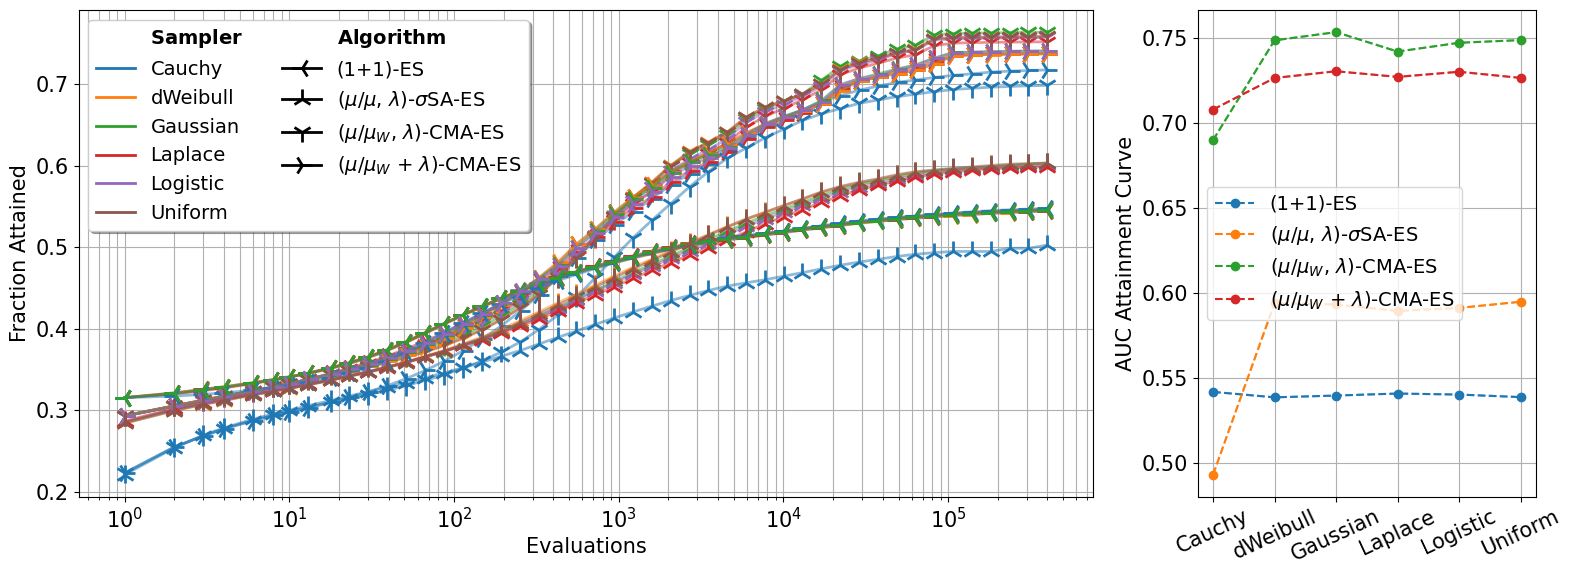

In [18]:

colors = dict(zip(samplers, mcolors.TABLEAU_COLORS))
markers = dict(zip(algs, "1234"))

linestyle = 'solid'
linewidth = 2
markersize= 15
markeredgewidth = 2

from matplotlib.lines import Line2D



aoccs = []
f, (ax, ax2) = plt.subplots(1, 2, figsize=(16, 6),  gridspec_kw={'width_ratios': [3, 1]})
aocc = []

for name, data in df.group_by("algorithm_name"):
    line = ins.transform_fval(data).group_by("evaluations").agg(pl.col("eaf").mean()).sort("evaluations")
    
    alg, sampler = name[0].split("-UNIFORM-")
    gi = 1
    d = 1
    aocc.append((gi, d, calc_aocc(line), alg, sampler))
    ax.semilogx(line['evaluations'], line['eaf'], c=colors[sampler], linestyle=linestyle, alpha=.5, linewidth=linewidth)
    ax.semilogx(line['evaluations'], line['eaf'], c=colors[sampler], marker=markers[alg], linestyle='', alpha=1, markersize=markersize, markeredgewidth=markeredgewidth)

aocc = pl.DataFrame(aocc, schema=["gi", "d", "aocc", "alg", "sampler"], orient='row')
aoccs.append(aocc)
    
handles = [Line2D([0], [0], linestyle='')]
labels = ["$\\bf{Sampler}$"]
for sampler, col in colors.items():
    handles.append(Line2D([0], [0], label=sampler, color=col, linestyle=linestyle, linewidth=linewidth)) 
    labels.append(sampler.title().replace("Scaled_", "").replace("Double_", "d"))


handles.append(Line2D([0], [0], linestyle=''))
labels.append("$\\bf{Algorithm}$")    


for alg, name in nice_alg_names.items():
    handles.append(Line2D([0], [0], label=alg, color='black', marker=markers[alg], linestyle=linestyle, linewidth=linewidth, markersize=markersize, markeredgewidth=markeredgewidth))
    labels.append(name)
    
handles.append(Line2D([0], [0], linestyle=''))
labels.append("")      
    
ax.legend(handles, labels, loc='upper left', fancybox=True, shadow=True, fontsize=14, ncol=2)
ax.set_ylabel("Fraction Attained")
ax.set_xlabel("Evaluations")
ax.grid(which="both", axis="both")


for alg, name in nice_alg_names.items():
    group = aocc.filter(aocc['alg'] == alg)
    idx = np.argsort(group['sampler'])
    x_values = np.array([samplers.index(g) for g in group['sampler'][idx]])
    p = ax2.plot(x_values, group['aocc'][idx], label=name, linestyle='dashed', marker='o')
    ax2.plot(x_values, group['aocc'][idx], marker=markers[alg], linestyle='dashed',  color=p[0].get_color(), alpha=.5)
    
ax2.legend(fontsize=14)
ax2.set_ylabel("AUC Attainment Curve")
ax2.set_xticks(range(len(samplers)), labels=[x.title().replace("Double_", "d").replace("Scaled_", "") for x in samplers], rotation=25)
ax2.grid()
# ax2.set_ylim(.41, .8)

# f.suptitle(f"Group: {gi}")
plt.tight_layout()
plt.savefig(f"figures/overview_ecdf.pdf")
# ax.set_ylim(0, 1.01);

aoccs = pl.concat(aoccs)

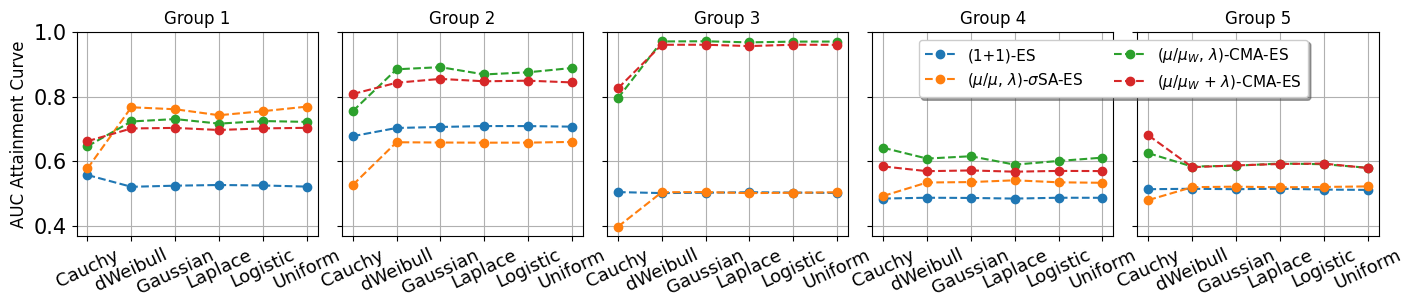

In [24]:
function_groups = (
    (1,2,3, 4, 5),
    (6, 7, 8, 9),
    (10, 11, 12, 13, 14),
    (15, 16, 17, 18, 19),
    (20, 21, 22, 23, 24)
)

aocc = []
for gi, funcs in enumerate(function_groups, 1):
    for name, data in df.group_by("algorithm_name"):
        data = data.filter(pl.col("function_id").is_in(funcs))
        line = ins.transform_fval(data).group_by("evaluations").agg(pl.col("eaf").mean()).sort("evaluations")
        
        alg, sampler = name[0].split("-UNIFORM-")
        aocc.append((gi, calc_aocc(line), alg, sampler))
        ax.semilogx(line['evaluations'], line['eaf'], c=colors[sampler], linestyle=linestyle, alpha=.5, linewidth=linewidth)
        ax.semilogx(line['evaluations'], line['eaf'], c=colors[sampler], marker=markers[alg], linestyle='', alpha=1, markersize=markersize, markeredgewidth=markeredgewidth)

aoccs = pl.DataFrame(aocc, schema=["gi", "aocc", "alg", "sampler"], orient='row')

f, axes = plt.subplots(1, 5, figsize=(14, 3), sharey=True)
for gi, ax in enumerate(axes.ravel(), 1):
    
    for alg in nice_alg_names:
        group =  aoccs.filter(gi=gi, alg=alg)
        idx = np.argsort(group['sampler'])
        ax.plot(group['sampler'][idx], group['aocc'][idx], label=nice_alg_names[alg], marker='o', linestyle='dashed')
    
    if gi == 5: 
        h, l = ax.get_legend_handles_labels()   
        ax.legend(np.array(h), np.array(l), loc='upper center',
                fontsize=11, bbox_to_anchor=(-.1, 1), fancybox=True, shadow=True, ncol=2,
        )
    if gi == 1:
        ax.set_ylabel("AUC Attainment Curve", fontsize=12)
        
    ax.set_xticks(range(len(samplers)), labels=[x.title().replace("Double_", "d").replace("Scaled_", "") for x in samplers], rotation=25, fontsize=13)
    ax.grid()
    ax.set_title(f"Group {gi}", fontsize=12)
    
plt.subplots_adjust(wspace=0.1, bottom=.2, left=0.05, right=.98)
plt.savefig("figures/auc_per_group.pdf")